Hi All,

Thanks for checking this out. I basicly;
* first rescaled the features, in order to avoid one field's dominance in the model. 
* then log transformed SalePrice and some skewed fields
* enumerated Categorical Features and ended up with too many fields. Instead of a vanilla regularization, I preselected 50% of the fields via mutual information gain calculation
* then applied Ridge Regularization.

Note: I was inspired by some of the ideas from <a href = "https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models">this great post</a> . Thanks 
<a href = "https://www.kaggle.com/apapiu">Alexandru</a> !

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
import seaborn as sns

#visualization tools
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
%matplotlib inline

#machine learning tools
from minepy import MINE
from sklearn.linear_model import Ridge, LinearRegression
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mutual_info_score

#statistics
from scipy.stats import skew

#ignore warning
import warnings
warnings.filterwarnings("ignore")

### First Let's load the data

In [3]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")
print train.shape

(1460, 81)


### Pre-Process the data

In [4]:
#discard some outliers
train.drop(train[train["GrLivArea"] > 4000].index, inplace=True)

In [5]:
#we need to preprocess the data together (both tarining and test set)
all_features = pd.concat((train.drop(["SalePrice"], axis = 1),test)).drop(["Id"], axis = 1)

In [7]:
Categorical_Parameters = all_features.columns[list(all_features.dtypes == "object")]

In [8]:
#enumerate the categorical fields
all_features_categorical = pd.get_dummies(all_features[Categorical_Parameters])

In [9]:
Numerical_Parameters = all_features.columns[list(all_features.dtypes != "object")]

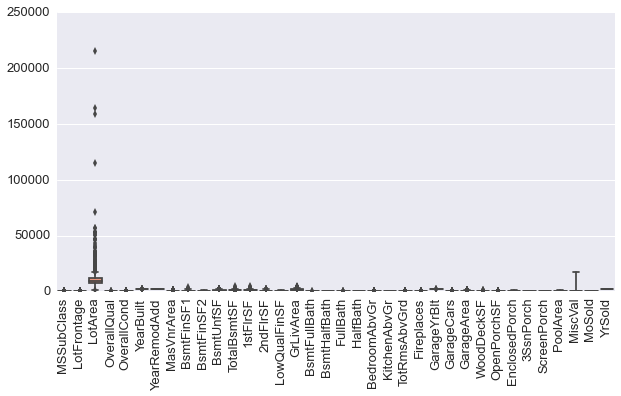

In [10]:
#check whether the fields are in similar ranges
plt.figure(figsize=(10,5))
ax1 = sns.set_style("whitegrid")
ax1 = sns.set(font_scale=1.3)
ax1 = sns.boxplot(all_features[Numerical_Parameters])
ax1 = plt.xticks(rotation=90)

In [11]:
#"LotArea" and "MiscVal" seems especially severe but lets keep all features in the same range
def normalize_column(s):
    return s/s.max()

for num_par in Numerical_Parameters:
    all_features[num_par] = normalize_column(all_features[num_par])

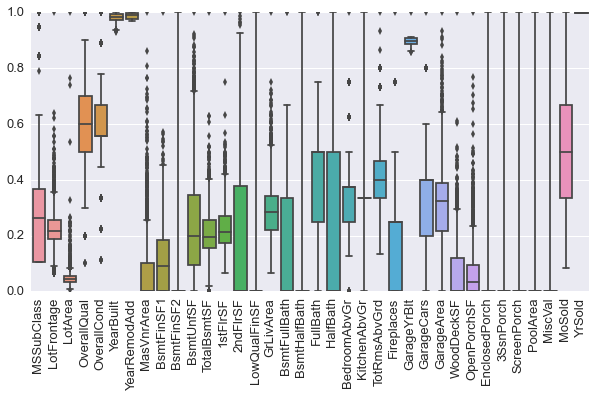

In [12]:
#Lets visualize again and it will look better
plt.figure(figsize=(10,5))
ax1 = sns.set_style("whitegrid")
ax1 = sns.set(font_scale=1.3)
ax1 = sns.boxplot(all_features[Numerical_Parameters])
ax1 = plt.xticks(rotation=90)

In [13]:
skewed = all_features[Numerical_Parameters].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
all_features[skewed] = np.log(all_features[skewed] + 1)

In [14]:
all_features_preprocessed = pd.concat((all_features[Numerical_Parameters], all_features_categorical), axis = 1)
all_features_preprocessed = all_features_preprocessed.fillna(all_features_preprocessed.mean())

# Feature Selection

In [15]:
train_processed = all_features_preprocessed.iloc[0:train.shape[0]]
test_processed = all_features_preprocessed.iloc[train.shape[0]:]

In [16]:
# find the mutual information gain
# use the 10%
# try different percentages later
m = MINE()

parameters = []
for x in train_processed.columns:
    m.compute_score(train_processed[x].astype(float), train.SalePrice.astype(float))
    parameters.append(m.mic())

In [17]:
param_num = len(parameters)
kept_param_num = int(param_num * 0.10)
parameters_sorted = sorted(parameters)
most_informative_params = []
for i in reversed(range((param_num - kept_param_num) , param_num)):
    most_informative_params.append(train_processed.columns[parameters.index(parameters_sorted[i])])

## Vanilla Linear Regression

'LM-Score  : 0.879807080493'

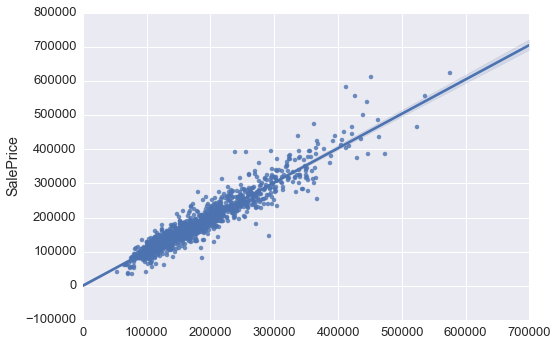

In [18]:
#create a linear regression object
lm = LinearRegression()
#Preapre the feature space
lm.fit(train_processed[most_informative_params], np.log(train.SalePrice + 1))
#display(pd.DataFrame({"features" : most_informative_params, "coefficients":lm.coef_}))
Predictions = lm.predict(train_processed[most_informative_params])
sns.regplot(np.exp(Predictions),train.SalePrice)
"LM-Score  : " + str(lm.score(train_processed[most_informative_params],np.log(train.SalePrice + 1)))

In [19]:
test_processed = pd.concat((test_processed, test.Id.astype(int)), axis = 1)

In [20]:
#create a linear regression object
lm = LinearRegression()
#Prepare the feature space
lm.fit(train_processed[most_informative_params], np.log(train.SalePrice + 1))
Predictions = lm.predict(test_processed[most_informative_params])
submission = pd.DataFrame(test_processed.Id)
submission["SalePrice"] = np.exp(Predictions)
submission[submission[['SalePrice']]<0] = 0

In [21]:
#Rank 1858 in 2665
#submission.to_csv("submission_vanilla_regression.csv", index = None)

# Regression with L2 Regularization
ideas from https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models

In [22]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train_processed[most_informative_params], np.log(train.SalePrice + 1), scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

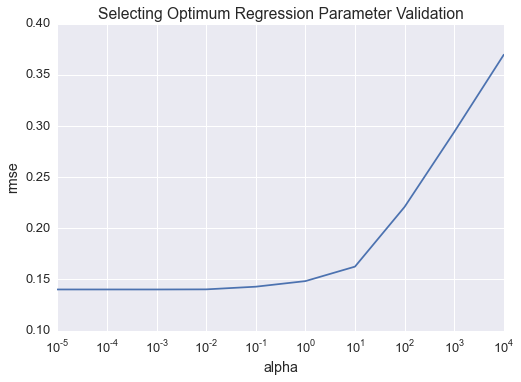

In [23]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
#alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(logx=True,title = "Selecting Optimum Regression Parameter Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [24]:
min(list(cv_ridge))

0.14022985466280907

In [25]:
#Best alpha is 0.001
#top 10 percent of the parameters
model = Ridge(alpha = 0.01)
model.fit(train_processed[most_informative_params], np.log(train.SalePrice + 1))
Predictions = model.predict(test_processed[most_informative_params])
submission = pd.DataFrame(test_processed.Id)
submission["SalePrice"] = np.exp(Predictions)
submission[submission[['SalePrice']]<0] = 0
#submission.to_csv("submission_ridge.csv", index = None) #Rank 1852 in 2665

# What if we use different top percentages of the data?
#keep alpha constant

In [26]:
def rmse_cv_dataCutoff(model, data):
    rmse= np.sqrt(-cross_val_score(model, train_processed[data], np.log(train.SalePrice + 1), scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [27]:
def select_most_informative_params(percentage):
    percentage = percentage/100.0
    param_num = len(parameters)
    kept_param_num = int(param_num * percentage)
    parameters_sorted = sorted(parameters)
    most_informative_params = []
    for i in reversed(range((param_num - kept_param_num) , param_num)):
        most_informative_params.append(train_processed.columns[parameters.index(parameters_sorted[i])])
    return most_informative_params

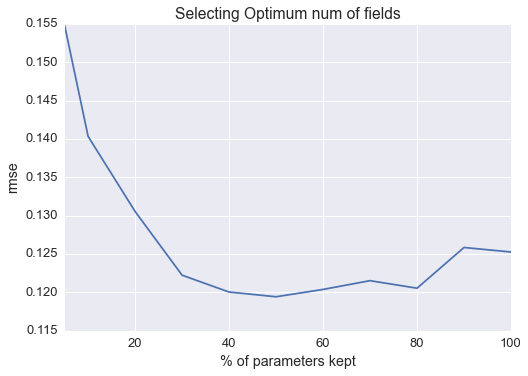

In [28]:
params = [select_most_informative_params(5), select_most_informative_params(10),\
          select_most_informative_params(20),select_most_informative_params(30),\
          select_most_informative_params(40),select_most_informative_params(50),\
          select_most_informative_params(60),select_most_informative_params(70),\
          select_most_informative_params(80),select_most_informative_params(90),\
          select_most_informative_params(100)]
cv_ridge_data = [rmse_cv_dataCutoff(Ridge(alpha = 0.01), param).mean() 
            for param in params]
cv_ridge_data = pd.Series(cv_ridge_data, index = [5,10,20,30,40,50,60, 70, 80, 90,100])
cv_ridge_data.plot(title = "Selecting Optimum num of fields")
plt.xlabel("% of parameters kept")
plt.ylabel("rmse")

In [29]:
min(list(cv_ridge_data))

0.11943694008408731

In [30]:
#Best alpha is 0.001
#top 10 percent of the parameters
model = Ridge(alpha = 0.01)
#use more data
model.fit(train_processed[select_most_informative_params(50)], np.log(train.SalePrice + 1))
Predictions = model.predict(test_processed[select_most_informative_params(50)])
submission = pd.DataFrame(test_processed.Id)
submission["SalePrice"] = np.exp(Predictions)
submission[submission[['SalePrice']]<0] = 0
submission.to_csv("submission_ridge_with_more_prior_data_v2.csv", index = None) #Rank 593 in 2665